In [10]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#load the dataset
data_path = '/Users/ceciliatorres/Desktop/Personal work/maintenance_risk/maintenance_risk/data/data.csv'
df = pd.read_csv(data_path)


In [3]:
#drop duplicates
df = df.drop_duplicates()

#check for missing values (to ensure data completeness before modeling)
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64


Now we identify extreme values that may skew model training and reduce performance.

In [4]:
#detect outliers
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outlier_counts = {}
for col in df.columns[:-1]:  #exclude target column 'fail'
    outliers = detect_outliers_iqr(df, col)
    outlier_counts[col] = len(outliers)

print("Outlier counts per feature:")
print(outlier_counts)

Outlier counts per feature:
{'footfall': 154, 'tempMode': 0, 'AQ': 0, 'USS': 0, 'CS': 87, 'VOC': 0, 'RP': 0, 'IP': 0, 'Temperature': 48}


Since footfall have 154 outliers, we apply log transformation to reduce skewness and make the distribution more suitable for modeling.


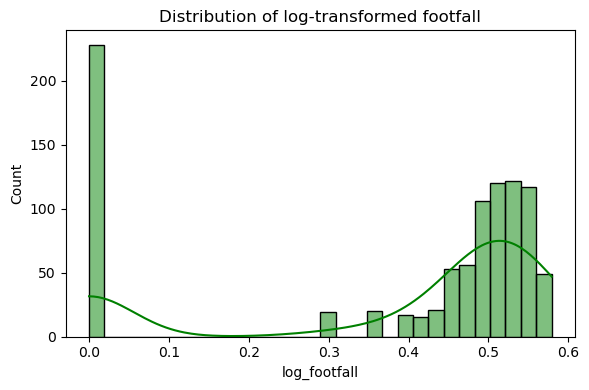

In [12]:
#transform footfall
df['footfall'] = np.log1p(df['footfall'])
plt.figure(figsize=(6,4))
sns.histplot(df['footfall'], kde=True, color='green', bins=30)
plt.title('Distribution of log-transformed footfall')
plt.xlabel('log_footfall')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


The `footfall` variable was heavily right-skewed with many extreme values. To stabilise the variance and improve model performance, I applied a log transformation using `log1p(x) = log(1 + x)`. The resulting distribution is much closer to normal.


Now we can define feature matrix X and target vector y: 

In [13]:
X = df.drop(columns=['fail'])
y = df['fail']


Now we can split the dataset into training and testing sets to evaluate model performance on unseen data.


In [14]:

from sklearn.model_selection import train_test_split

#split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#print the shape
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (754, 9)
Test shape: (189, 9)


Now we can save the processed datasets for consistent reuse across modeling experiments (with Pickle)

In [16]:
import joblib
import os

os.makedirs("processed_data", exist_ok=True)
joblib.dump((X_train, X_test, y_train, y_test), "processed_data/train_test_split.pkl")


['processed_data/train_test_split.pkl']

In [ ]:
#to save separately 
joblib.dump(X_train, base_path + 'X_train.pkl')
joblib.dump(X_test, base_path + 'X_test.pkl')
joblib.dump(y_train, base_path + 'y_train.pkl')
joblib.dump(y_test, base_path + 'y_test.pkl')
